# 6. support vector machines
给定训练集样本 $D=\{(x_1,y_1),(x_2,y_2),...(x_m,y_m)\}, y\in\{-1,+1\}$,分类学习最基本的想法就是基于训练集D在样本空间中找到一个划分超平面，将不同类别的样本分开。由于数据点都在二维平面上，所以此时分割超平面就是一个平面。更高维的情况可以以此类推。如果数据集是三维的，那么此时用来分割数据的就是一个平面。超平面也就是分类的决策边界，分布在超平面一侧的所有数据都数以某个分类，另一侧的数据则属于另一个类别。

如果数据点离决策越远，那么其最后的预测结果也就越可信。我们希望找到离分割超平面最近的点，确保他们离分隔超平面的距离尽可能的大。这里点到分隔面的距离被称为间隔。

支持向量（support vector）就是离分隔超平面最近的那些点。

在样本空间中，分隔超平面可以用如下的线性方程来描述$w^Tx+b=0$，其中$w = (w_1;w_2....;w_d)$为法向量，决定了超平面的方向；b为位移项，决定了超平面与原点之间的距离。显然超平面可以被法向量w和位移b确定，将其记为$(w,b)$，样本空间中任一点x到超平面$(w,b)$的距离可写为$r = \frac{||w^TA+b||}{||w||}$。

假设超平面$(w,b)$能将训练样本正确分类，即对$(x_i,y_i)\in D$若$y_i=+1$，则有

$\begin{cases}
w^Tx_i+b\ge+1, y_i=+1\\
w^Tx_i+b\le-1,y_i=-1
\end{cases}
$

![svm.png](svm.png)

如图所示，距离超平面最近的这几个训练样本点使等号成立，他们被称为“支持向量”两个异类支持向量到超平面的距离之和为$r = \frac{2}{||w||}$，他被称为“间隔”。欲找到具有“最大间隔”(maximum margin)的划分超平面，也就是要找到能满足式中约束的参数$w$和$b$使得r最大，即

$
\max\limits_{w,1}\frac{2}{||w||} \\
s.t. \qquad y_i(w^Tx_i+b)\ge1, i = 1,2,...m
$

为了最大化间隔，仅需最大化$||w||^-1$，这个等价于最小化$||w||$于是可重写为：

$
\min\limits_{w,b} \frac{1}{2}||w||^2 \\
s.t. \qquad y_i(w^Tx_i+b)\ge1, i=1,2,...m
$

这就是支持向量机的基本型。

简化版的SMO算法：

platt SMO算法中的外驯化确定要优化的最佳alpha对。而简化版的却会跳过这一部分，首先在数据集上遍历每一个alpha，然后在剩下的alpha集合中随机选择另一个alpha，从而构架alpha对。这里有一点相当重要，就是要同时改变两个alpha。之所以这样做是因为有一个约束条件：$\sum a_i \cdot label^{(i)}=0$由于改变一个alpha可能会导致该约束条件失效，因此总是同时改变这两个alpha。

In [20]:
import random

'''从某个范围内随机选择一个整数
    i : alpha的下标
    m : 所有alpha的数目

'''
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j


# 在数值过大时对其进行调整，确保aj在high和low之间
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

SMO函数的伪代码大致如下：
```
创建一个alpha向量并将其初始化为0向量
当迭代次数小于最大迭代次数时（外循环）
    对数据集中的每个数据向量（内循环）：
        如果该数据向量可以被优化：
            随机选择另一个数据向量
            同时优化这两个向量
            如果两个向量都不能被优化，退出内循环
    如果所有向量都没被优化，增加迭代数目，继续下一次循环
```

In [21]:
import pandas as pd
import numpy  as np

In [36]:
'''
    参数： dataMatIn: 数据集
          classLabels: 标签
          C :常数C
          toler: 容错率
          maxIter： 最大循环次数
    
    返回值： b,alpha 
'''

def smoSimple(dataMatIn, classLabels, C: int, toler: float, maxIter: int):
    dataMatrix = np.mat(dataMatIn)
    labelMatrix = np.mat(classLabels).transpose()
    # w^Tx+b确定一个超平面
    b = 0
    m,n = dataMatrix.shape
    alphas = np.mat(np.zeros((m,1)))
    iternum = 0
    
    while(iternum < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            # multiply数组和矩阵对应位置相乘，输出与相乘数组/矩阵的大小一致
            # alphas m*1 转置之后 1*m
            # dataMatrix[i,:] 是取第i行 1*n 转置之后是 n*1,dataMatrix是m*n 两者相乘是m*1
            # fXi 是由1×m和m*1两个向量相乘而来，是一个常数
            fXi = float(np.multiply(alphas, labelMatrix).T*(dataMatrix*dataMatrix[i,:].T))+b
            Ei = fXi - float(labelMatrix[i])
            if ((labelMatrix[i]*Ei < -toler) and (alphas[i] < C)) or \
            ((labelMatrix[i]*Ei > toler) and (alphas[i]>0)):
                j = selectJrand(i,m)
                fXj = float(np.multiply(alphas,labelMatrix).T*(dataMatrix*dataMatrix[j,:].T))+b
                Ej = fXj - float(labelMatrix[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                if (labelMatrix[i]!=labelMatrix[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H");continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - \
                    dataMatrix[i,:]*dataMatrix[i,:].T - \
                    dataMatrix[j,:]*dataMatrix[j,:].T
                if eta>=0: print("eta>=0");continue
                alphas[j] -= labelMatrix[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("j not moving enough")
                    continue
                alphas[i] += labelMatrix[j]*labelMatrix[i]*(alphaJold - alphas[j])
                b1 = b - Ei - labelMatrix[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - \
                    labelMatrix[j] * (alphas[j] - alphaJold) * dataMatrix[i,:] * dataMatrix[j,:].T
                b2 = b - Ej - labelMatrix[i] * (alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - \
                    labelMatrix[j]*(alphas[j]-alphaJold) * dataMatrix[j,:]*dataMatrix[j,:].T
                if (0<alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1+b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i: %d, pairs cahnged %d" % (iternum, i, alphaPairsChanged))
                
        if  alphaPairsChanged==0:
            iternum += 1
        else:
            iternum = 0
        print("iteration number: %d " %iternum)
    return b,alphas

In [37]:
df = pd.read_csv("testSet.txt", sep='\t')
dataArr = df.iloc[:,0:2]
labels = df.labels
b,alpha = smoSimple(dataArr, labels, 0.6, 0.0001, 40)

iter: 0 i: 0, pairs cahnged 1
j not moving enough
j not moving enough
iter: 0 i: 5, pairs cahnged 2
L==H
j not moving enough
iter: 0 i: 10, pairs cahnged 3
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i: 54, pairs cahnged 4
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
iter: 0 i: 1, pairs cahnged 1
j not moving enough
j not moving enough
iter: 0 i: 10, pairs cahnged 2
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i: 69, pairs cahnged 3
j not moving enough
iteration number: 0 
j not moving enough
iter: 0 i: 1, pairs cahnged 1
j not moving enough
L==H
L==H
j not moving enough
iter: 0 i: 29, pairs cahnged 2
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i: 82, pairs cahnged 3
iteration number: 0 
iter: 0 i: 0, pa

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3 
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 3 i: 52, pairs cahnged 1
j not moving enough
j not moving enough
iter: 3 i: 69, pairs cahnged 2
iteration number: 0 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 55, pairs cahnged 1
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
iter: 0 i: 29, pairs cahnged 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1 
j not moving enough
j not moving enough
j not moving enough
j not 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5 
iter: 5 i: 17, pairs cahnged 1
j not moving enough
iter: 5 i: 52, pairs cahnged 2
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1 
j not moving enough
j not moving enough
iter: 1 i: 29, pairs cahnged 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
j not moving enough
j not moving enough
j not moving enough


iteration number: 16 
j not moving enough
j not moving enough
j not moving enough
iteration number: 17 
j not moving enough
j not moving enough
j not moving enough
iteration number: 18 
j not moving enough
j not moving enough
iteration number: 19 
j not moving enough
j not moving enough
iteration number: 20 
j not moving enough
j not moving enough
iteration number: 21 
j not moving enough
j not moving enough
iteration number: 22 
j not moving enough
j not moving enough
iteration number: 23 
j not moving enough
j not moving enough
iteration number: 24 
j not moving enough
j not moving enough
iteration number: 25 
j not moving enough
j not moving enough
iteration number: 26 
j not moving enough
j not moving enough
iteration number: 27 
iter: 27 i: 29, pairs cahnged 1
j not moving enough
j not moving enough
iteration number: 0 
j not moving enough
j not moving enough
iteration number: 1 
j not moving enough
j not moving enough
iteration number: 2 
j not moving enough
j not moving enough
i

In [38]:
b

matrix([[-3.82752323]])

In [39]:
alpha[alpha>0]

matrix([[0.17344077, 0.08465196, 0.10752104, 0.36561376]])

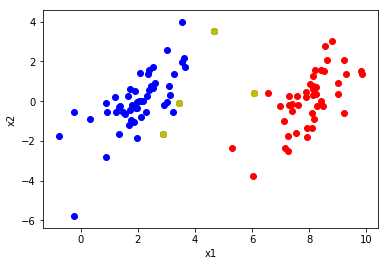

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
pos = df[df['labels']==1]
neg = df[df['labels']==-1]
plt.scatter(pos['x1'], pos['x2'], c='r')
plt.scatter(neg['x1'], neg['x2'], c='b')
plt.xlabel("x1")
plt.ylabel('x2')
# 输出支持向量
for i in range(100):
    if alpha[i]>0.0:
        dataArr = np.array(dataArr)
        plt.scatter(dataArr[i][0], dataArr[i][1], c='y')

plt.show()